In [100]:
import os

In [101]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [102]:
os.chdir("../.")

In [103]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [104]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [105]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    metric_file_name: Path
    target_column: str
    params: dict[str, str]
    grid_search_model_path: Path
    train_data_path: Path
    
     
    

In [106]:
from BankProducts.constants import *
from BankProducts.utils.common  import read_yaml, create_directories
from BankProducts   import logger



In [107]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation   
        params = self.params.random_forest
        schema =  self.schema.target_column

        create_directories([self.config.artifacts_root])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config.root_dir),
            test_data_path=Path(config.test_data_path),
            model_path=Path(config.model_path),
            metric_file_name=Path(config.metric_file_name),
            target_column=schema.name,
            params=params,
            grid_search_model_path= Path(config.grid_search_model_path),
            train_data_path=Path(config.train_data_path)
            
            
           
            
        )

        return model_evaluation_config

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from BankProducts import logger
import seaborn as sns
from matplotlib import pyplot as plt
import tempfile
import mlflow
import joblib
from sklearn.preprocessing import LabelEncoder
from BankProducts.utils.common import save_json
from urllib.parse import urlparse
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')



In [ ]:
class ModelEvaluation:
    def __init__(self, config):
        self.config = config

    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()
        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="bank_products_recommender")

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        test_x = test_data.drop(columns=[self.config.target_column])
        test_y = test_data[self.config.target_column]

        # Encode the target variable
        le = LabelEncoder()
        test_y_encoded = le.fit_transform(test_y)

        logger.info("Loading model from path: %s", self.config.model_path)
        pipeline = joblib.load(self.config.model_path)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.set_experiment("Product Recommender")

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            predicted = pipeline.predict(test_x)

            accuracy, precision, recall, f1 = self.eval_metrics(test_y_encoded, predicted)
            
             # evaluate the model
            rf_report = classification_report(test_y_encoded, predicted)
            rf_cm = confusion_matrix(test_y_encoded, predicted)   
            rf_accuracy = accuracy_score(test_y_encoded, predicted)   
            
            #create Confusion Matrix Display
            cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=le.classes_)
            plt.figure(figsize=(10, 8))         
            plt.title("RandomForestClassifier Matrix")
            cm_display.plot()
            plt.xticks(rotation=180)
            
            

            logger.info(f"RandomForest Classification Report:\n{rf_report}")
            logger.info(f"RandomForest Confusion Matrix:\n{rf_cm}") 
            logger.info(f"RandomForest Accuracy: {rf_accuracy}")
            

            scores = {
                "model_name": "random_classifier",
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }
            
            # Ensure directory exists
            Path(self.config.metric_file_name).parent.mkdir(parents=True, exist_ok=True)

            save_json(Path(self.config.metric_file_name), data=scores)
            
            logger.info("Metrics saved to: %s", self.config.metric_file_name)
            
            logger.info("Logging accuracy")
            mlflow.log_metric("accuracy", accuracy)

            logger.info("Logging precision")
            mlflow.log_metric("precision", precision)

            logger.info("Logging recall")
            mlflow.log_metric("recall", recall)

            logger.info("Logging f1_score")
            mlflow.log_metric("f1_score", f1)

            logger.info("Setting class_names")
            class_names = le.classes_

            logger.info("Logging confusion matrix")
            self.log_confusion_matrix(test_y_encoded, predicted, class_names)

            logger.info("Logging classification report")
            self.log_classification_report(test_y_encoded, predicted, class_names)
            
            
            logger.info("Tracking URI scheme: %s", tracking_url_type_store)
            logger.info("Tracking URI: %s", mlflow.get_tracking_uri())


            #if tracking_url_type_store != "file":
                #mlflow.sklearn.log_model(pipeline, "pipeline", registered_model_name="product recommender")
            #else:
                #mlflow.sklearn.log_model(pipeline, "pipeline")
              
            logger.info("mlflow model logged successfully.")
            
            
            
            

    # perform a Grid Search to find the best model
    def perform_grid_search(self):
        from sklearn.model_selection import GridSearchCV
        from sklearn.pipeline import Pipeline
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        from sklearn.compose import ColumnTransformer

        # Load **training** data for grid search
        train_data = pd.read_csv(self.config.train_data_path)
        X_train = train_data.drop(columns=[self.config.target_column])
        y_train = train_data[self.config.target_column]

        # Define preprocessing steps
        numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        # Define the model
        model = RandomForestClassifier(random_state=42)

        # Create a pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        # Define hyperparameter grid
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__max_features': ['sqrt', 'log2'], 
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced', None],
            'classifier__n_jobs': [-1]
        }

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)

        logger.info("Best parameters found: %s", grid_search.best_params_)

        # Save the best model
        joblib.dump(grid_search.best_estimator_, self.config.grid_search_model_path)
        logger.info("Best model saved to: %s", self.config.grid_search_model_path)

        #  Feature importance works only with numeric column names (after encoding)
        # This part needs to be handled carefully after transformation
        try:
            classifier = grid_search.best_estimator_.named_steps['classifier']
            importances = classifier.feature_importances_

            # Just return dummy placeholder since true mapping is complicated
            importance_df = pd.DataFrame({'importance': importances})
        except Exception as e:
            logger.warning("Could not extract feature importances: %s", e)
            importance_df = pd.DataFrame()

        return importance_df

                                                                        
    
    
    # perform validation using cross validation
    def validate_model(self):
        test_data = pd.read_csv(self.config.test_data_path)
        test_x = test_data.drop(columns=[self.config.target_column])
        test_y = test_data[self.config.target_column]

        pipeline = joblib.load(self.config.model_path)

        # Perform cross-validation
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(pipeline, test_x, test_y, cv=5, scoring='accuracy')

        logger.info("Cross-validation scores: %s", scores)
        logger.info("Mean cross-validation score: %.2f", scores.mean())

        return scores.mean()
            
    
        
 
    

[2025-06-06 23:12:45,192: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-06 23:12:45,198: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-06 23:12:45,205: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-06 23:12:45,207: INFO: common: created directory at: artifacts]
[2025-06-06 23:12:45,209: INFO: common: created directory at: artifacts]
[2025-06-06 23:12:45,246: INFO: 2871826739: Loading model from path: artifacts\model_training\random.joblib]
[2025-06-06 23:12:46,074: INFO: 2871826739: RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       534
           1       1.00      1.00      1.00       716
           2       1.00      1.00      1.00       374
           3       1.00      1.00      1.00      1049
           4       1.00      1.00      1.00       211
           5       1.00      1.00      1.00       372
           6       1.00    

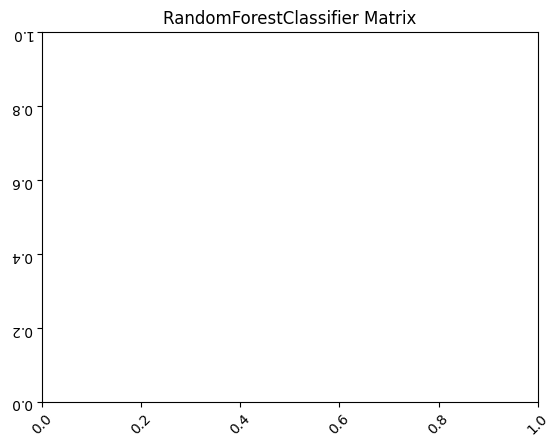

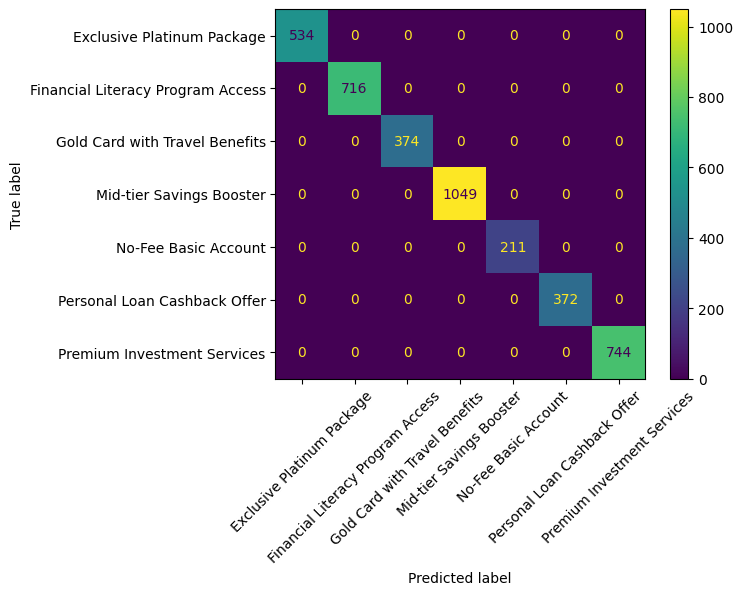

In [110]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    eval = ModelEvaluation(config=model_evaluation_config)
    eval.log_into_mlflow()
    #eval.validate_model()
    #eval.feature_importance()
    #eval.perform_grid_search()  
    
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    
    